# Probabilistic Algorithms: Approximate Counting, \*LogLog and Bloom Filters 

In [1]:
import numpy as np
import pandas as pd
from ggplot import *

import warnings
warnings.filterwarnings('ignore')

## Approximate Counting <cite data-cite="4353254/AWZPQJD8"></cite>

In the 70s Morris had to count the occurences of some events, but he only had 8-bits to count each of them (255 being the maximum value). Due to this limitation many common events shared the same value of 255, even though some of them were much more frequent (and it was important to discern them). However, a precise count was not necessary, it was enough to know only the order of the magnitude of the events occurence. This resulted in the development of what is called nowadays the Approximate Counting algorithm <cite data-cite="4353254/AWZPQJD8"></cite>.

Lets assume that our base is $b$, and thus we can count $b^{0}, b^{1}, b^{2}, \dots, b^{k}$. Moreover, lets call our expoent a counter $c$, which is going to be the output of the algorithm. We have to devise an strategy to either increment or to leave $c$ as it is for each time that an event occurs. The strategy is to compute $\frac{1}{\Delta} = b^{c + 1} - b^{c}$, which we know that $0 \leq \Delta < 1$. Then, we draw a number $r$ from an uniform distribution ($0 \leq r < 1$). If $\Delta > r$ we increment $c$, otherwise leave as it is.

To better understand lets illustrate it with an example. Let $b=2$ and $c=4$. 16 events should happen before we increase $c$ to 5, as $2^{5} - 2^{4} = 16$. In fact, $\Delta = \frac{1}{16}$, and we can see 16 as $2^{4}$, then $\Delta$ can be interpreted as flipping a coin 4 times and expecting to land head all 4 times. If it lands head 4 times we increment $c$. The code below illustrates this case of $b=2$.

In [2]:
def event(counter):
    trials = np.random.binomial(counter, 0.5, 1)
    if (np.sum(trials) == counter):
        return True
    return False

Lets run it 10 times on a scenario of 10,000 events ($2^{14} = 16,384$) to see its accuracy.

In [3]:
def counting_RMorris():
    df = pd.DataFrame(data=np.nan, index=range(0,10000), columns=['index', 'counter'])
    counter = 0
    for i in range(0, 10000):
        if event(counter):
            counter = counter + 1
        df.loc[i] = [i + 1, counter]
    return df

In [4]:
runs = pd.DataFrame()
for r in range(0,10):
    df = counting_RMorris()
    df['run'] = str(r + 1)
    runs = runs.append(df)

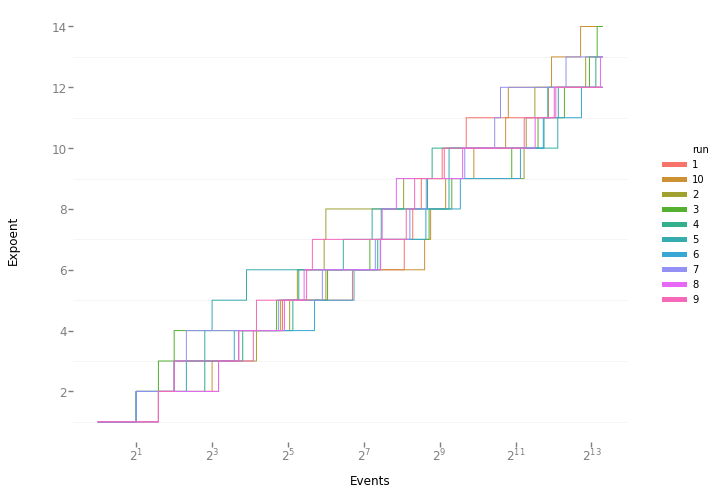

<ggplot: (-9223372036560485716)>

In [5]:
ggplot(aes(x='index', y='counter', group='run', color='run'), data=runs) + scale_x_log(2) + geom_step() \
    + xlab('Events') + ylab('Expoent') + theme_bw()

This algorithm has one parameter, the base $b$. Flajolet analysis shows that for $b=2$ its peformance remains remarkably stable over many increments. However, as he notes, one has to keep in mind the applications domain in order to assess if errors at this magnitude are acceptible <cite data-cite="4353254/PJUMZUX4"></cite>.

One possible application for Approximate Counting is to keep track of the amount of times a block of flash memory has been written, as these blocks can only endure a limited amount of write operations. Approximate Counting not only is good for this task because it only takes $loglog(n)$ bits, but its counter itself won't be rewritten every time. Thus, when the amount of space required to store a counter is worrisome, or when the action of writing the counter is expensive, this algorithm is a good candidate <cite data-cite="4353254/MQBS6DZC"></cite>.

## Hashing Functions and Dataset
The next algorithms/data structures make use of hashing functions, so before diving into them lets define the hashing functions that will be used. I note that some algorithms/data structures make assumptions about these hash functions, but none of them were tested. Futhermore, I constrain every hashing to have 24 bits.

In [6]:
import hashlib
import zlib

def hash_CRC32(s):
    return zlib.crc32(s) & 0xffffff

def hash_Adler32(s):
    return zlib.adler32(s) & 0xffffff

def hash_MD5(s):
    return int(hashlib.md5(s).hexdigest(), 16) & 0xffffff

def hash_SHA(s):
    return int(hashlib.sha1(s).hexdigest(), 16) & 0xffffff

hash_functions = [hash_CRC32, hash_Adler32, hash_MD5, hash_SHA]

Besides the hashing functions, lets also define the dataset. For the experiments I will use the following multiset of $W$ words:

In [7]:
import nltk
words = nltk.corpus.gutenberg.words('austen-persuasion.txt')
words = [x.lower().encode('utf-8') for x in words]
print(len(words))
words[1:8]

98171


[b'persuasion', b'by', b'jane', b'austen', b'1818', b']', b'chapter']

## Estimating Cardinality
Cardinality of a multiset is its number of unique elements. The naive and deterministic approach is to either sort it ($O(nlogn)$) and to then in one pass count the unique elements, or to trade-off space for speed by using a hashtable. Either way it is an expensive process, and probabilistic algorithms trade-off on accuracy to gain on speed and space.

One common use of algorithms to estimate cardinality are on relational databases, as there is a concern about query optimization <cite data-cite="4353254/MQBS6DZC"></cite>. Take for example the task of selecting the intersection of two multisets:
1. One approach would be to sort the multiset A (or B) and then for each member of the multiset B perform a search on A;
2. Another approach is to sort both multisets and perform a process similar to merge-sort;
3. Or maybe it would be better to remove the duplicates before executing 1 or 2.

One of the statistics used by relational databases to decide which path to take when doing query optimization is the cardinality <cite data-cite="4353254/DAQ74JZE"></cite>. Another use of cardinality estimation is on monitoring of network traffic, as an increase on unique destinations of the packets may indicate malicious activity <cite data-cite="4353254/GWIR2CKA"></cite>.

This section starts by explaining the Flajolet-Marting algorithm <cite data-cite="4353254/DAQ74JZE"></cite>, followed by its refinement called LogLog Counting <cite data-cite="4353254/E4UWFJNX"></cite> and the HyperLogLog Counting <cite data-cite="4353254/GWIR2CKA"></cite>, which seems to be the state of the art.

### Flajolet–Martin algorithm <cite data-cite="4353254/DAQ74JZE"></cite>
For this algorithm one needs to have a hash function that generates integers that are distributed in an sufficiently uniformly manner on the interval $[0, 2^{L} - 1]$, where $L$ is a parameter set by the user that defines the amount of bits that will be used. We also need to define one auxiliary function that returns the first 1-bit of the binary representation of the hash:

In [8]:
# note that this implementation is returning 2 to power of the first 1-bit
def least1(x, L):
    if x == 0:
        return 2**L
    return x & -x

Thus, if the hashes are uniformly distributed, we expected half of them to have the first bit set to 1, and a quarter of them to have the first bit set to 0 and the second to 1, and so on. The algorithm mainly consists of keeping track of these first-one bits patterns in a bitmap:

In [9]:
subset = words[0:1000]
bitmap = 0
for w in subset:
    h = hash_CRC32(w)
    bitmap |= least1(h, 24)
print(bin(bitmap))

0b11111111


From the bitmap one can extract the cardinality by this observation: if $n$ is the amount of unique elements in $W$, then we expect the bit at position $i$ to be 1 if $i \ll log_{2}(n)$, 0 if $i \gg log_{2}(n)$ and a mix of zeroes and ones at $i \approx log_{2}(n)$. So given the position of the first zero on the bitmap ($R$), a good candidate to estimate the cardinality of $W$ is to simply compute $2^{R}$, and as the authors of the algorithm demonstrated, one should also divide this number by a correction factor of $0.77351$, thus: $\frac{2^{R}}{0.77351}$.

In [10]:
def cardinality_FM(bitmap):
    return least1(~bitmap, 24) / 0.77351

print(cardinality_FM(bitmap))

330.9588757740688


In [11]:
from collections import Counter
print(len(Counter(subset)))

426


Besides the correction factor, the authors also demonstrated that one should expect the value to be off by one order of magnitude. In order to remedy this situation one could run multiple hashes/bitmaps and average the result.

In [12]:
subset = words[0:6000]
df = pd.DataFrame(data=np.nan, index=range(0, 5 * len(subset)), columns=['f', 'x', 'count'])
bitmaps = np.array([0] * 4)
s = set([])

for idx, w in enumerate(subset):
    s.add(w)
    for i, hash_function in enumerate(hash_functions):
        bitmaps[i] |= least1(hash_function(w), 24)
    
    df.loc[idx * 5] = ['True Counting', idx, len(s)]
    df.loc[idx * 5 + 1] = ['CRC32 Hash', idx, cardinality_FM(bitmaps[0])]
    df.loc[idx * 5 + 2] = ['Adler32 Hash', idx, cardinality_FM(bitmaps[1])]
    df.loc[idx * 5 + 3] = ['MD5 Hash', idx, cardinality_FM(bitmaps[2])]
    df.loc[idx * 5 + 4] = ['SHA Hash', idx, cardinality_FM(bitmaps[3])]

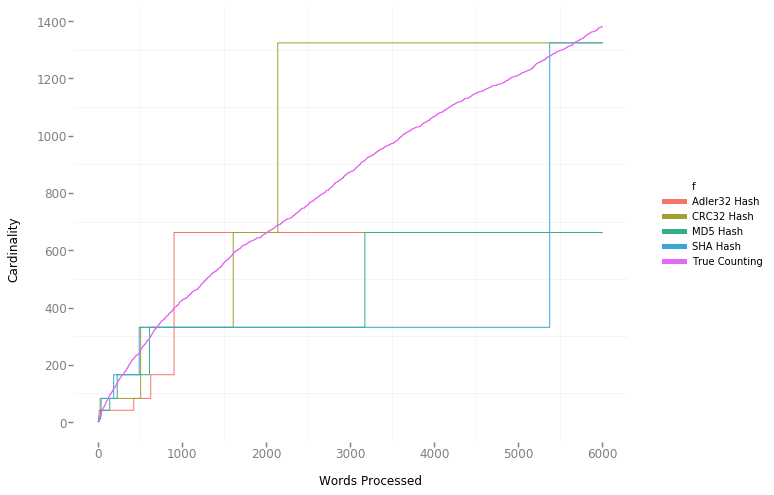

<ggplot: (-9223372036552085844)>

In [13]:
ggplot(aes(x='x', y='count', group='f', color='f'), data=df) + geom_step() + xlab('Words Processed') + ylab('Cardinality') + theme_bw()

### LogLog Counting <cite data-cite="4353254/E4UWFJNX"></cite>
From the previous algorithm it was noted that one possible opitmization would be to use multiple hash functions and keep multiple bitmaps. The LogLog Counting algorithm goes on a similar path as it keeps multiple buckets (they act similarly to bitmaps) but uses only one hash function, thus avoiding the additional cost of executing mutliple hash functions.

Lets define $m$ as the amount of buckets, with $m=2^{k}$. Thus we can use the first $k$ bits of the hash as the address of each bucket. Futhermore, lets call $R$ as the position of the first 1-bit after the $k$-bits. Each bucket will hold its maximum $R$, which is an estimation of $log_{2}(n)$. We can combine all of these estimations with the following equation:

$$E = \alpha m 2^{\frac{1}{m}\sum_{i=1}^{m}buckets[i]} $$

Where $\alpha$ is a correction factor that can be set as $0.39701$ for large values of $m$.

In [14]:
def index_least1(x):
    if x == 0:
        return 0
    index = 1
    while x % 2 == 0:
        x >>= 1
        index += 1
    return index

def cardinality_LogLog(buckets):
    buckets = [index_least1(x) for x in buckets]
    return 0.39701 * len(buckets) * 2 ** (np.mean(buckets))

In [15]:
subset = words[0:6000]
df = pd.DataFrame(data=np.nan, index=range(0, 4 * len(subset)), columns=['f', 'x', 'count'])

s = set([])
bitmap = 0
buckets16 = np.array([0] * 16)
buckets64 = np.array([0] * 64)

for idx, w in enumerate(subset):
    s.add(w)
    hashed = hash_SHA(w)
    
    bitmap |= least1(hashed, 24)
    buckets16[hashed % 16] = max(buckets16[hashed % 16], least1(hashed >> 4, 24))
    buckets64[hashed % 64] = max(buckets64[hashed % 64], least1(hashed >> 6, 24))
    
    df.loc[idx * 4] = ['True Counting', idx, len(s)]
    df.loc[idx * 4 + 1] = ['SHA Hash', idx, cardinality_FM(bitmap)]
    df.loc[idx * 4 + 2] = ['LogLog (16 buckets)', idx, cardinality_LogLog(buckets16)]
    df.loc[idx * 4 + 3] = ['LogLog (64 buckets)', idx, cardinality_LogLog(buckets64)]

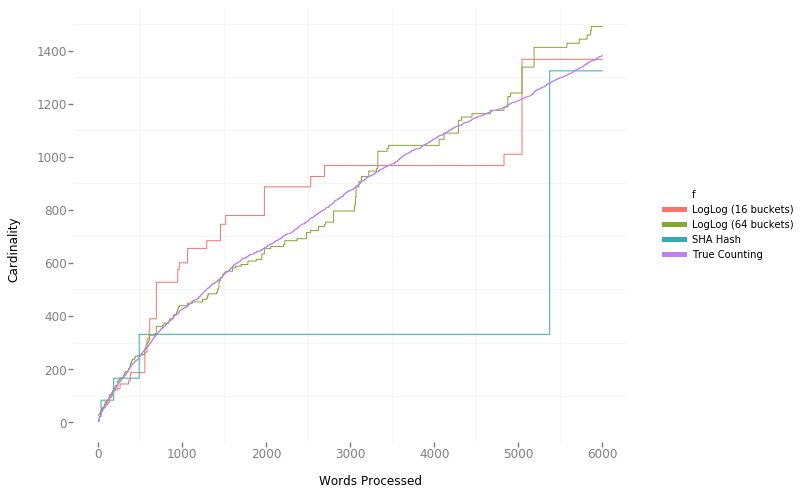

<ggplot: (-9223372036551523177)>

In [16]:
ggplot(aes(x='x', y='count', group='f', color='f'), data=df) + geom_step() + xlab('Words Processed') + ylab('Cardinality') + theme_bw()

As one can see there is a tremendous improvement on the accuracy. In fact, one can expect the accuracy to be in the order of $\frac{1}{\sqrt{m}}$.

### HyperLogLog <cite data-cite="4353254/GWIR2CKA"></cite>
HyperLogLog improves the LogLog algorithm by using harmonic means to average the buckets. Thus the cardinality is estimated by the following equation:

$$E = \frac{\alpha m^{2}}{\sum_{i = 1}^{m}2^{-buckets[i]}}$$

Where $\alpha = 0.72134$ for large values of $m$.

In [17]:
def cardinality_HyperLogLog(buckets):
    buckets = [1 if bucket == 0 else 1 / (bucket << 1) for bucket in buckets]
    return 0.72134 * len(buckets)**2 / np.sum(buckets)

In [18]:
subset = words[0:15000]
df = pd.DataFrame(data=np.nan, index=range(0, 4 * len(subset)), columns=['f', 'x', 'count'])

s = set([])
bitmap = 0
buckets = np.array([0] * 64)

for idx, w in enumerate(subset):
    s.add(w)
    hashed = hash_SHA(w)
    
    bitmap |= least1(hashed, 24)
    buckets[hashed % 64] = max(buckets[hashed % 64], least1(hashed >> 6, 24))
    
    df.loc[idx * 4] = ['True Counting', idx, len(s)]
    df.loc[idx * 4 + 1] = ['SHA Hash', idx, cardinality_FM(bitmap)]
    df.loc[idx * 4 + 2] = ['LogLog (64 buckets)', idx, cardinality_LogLog(buckets)]
    df.loc[idx * 4 + 3] = ['HyperLogLog (64 buckets)', idx, cardinality_HyperLogLog(buckets)]

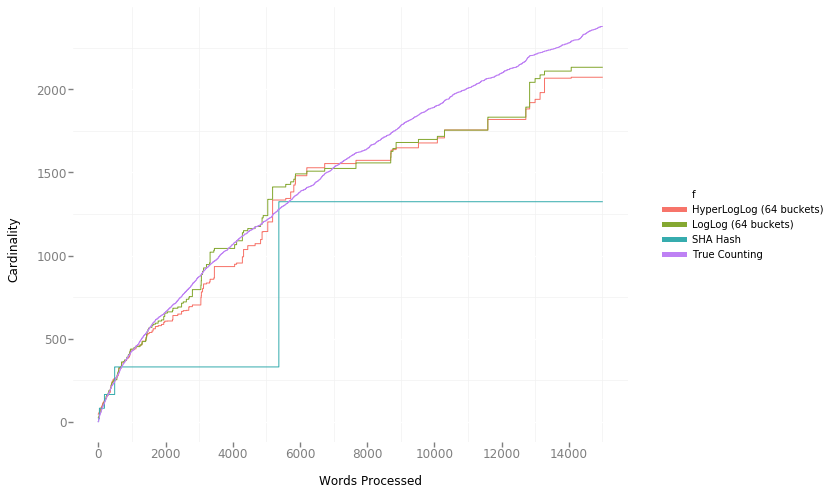

<ggplot: (-9223372036551186884)>

In [19]:
ggplot(aes(x='x', y='count', group='f', color='f'), data=df) + geom_step() + xlab('Words Processed') + ylab('Cardinality') + theme_bw()

Interestingly enough LogLog is more accurate than HyperLogLog. It may be an implementation mistake or for this dataset/hash function LogLog outperforms HyperLogLog. In any case, note how none of the algorithms makes any assumption about the data, their insertion order or how frequent the elements are repeated.

## Bloom Filters <cite data-cite="4353254/XC3R9KQX"></cite>
Bloom Filters is a data structure that allows one to know if an element is not in the set or if it is probably in the set. Thus its use is appropriate for enviroments where the majority of queries should return negative.

Lets assume that we have a bitmap of $N$ addresses ($[0, N - 1]$, all initially set to zero) and $d$ hash functions that have as output one of these $N$ addresses. In order to insert an element one has to compute the $d$ hash functions and mark $1$ at every $d$ address. Then to check if an element is not in the set, one computes the $d$ addresses and checks if at least one of them has the value of zero; if all of them have the value of 1, then probably the element is in the set.

From the way this data structure works it is important to note that using many hash functions is not necessearily good, as $d$ grows bigger so does the ratio of the elements set to 1 on the bitmap and thus leading to more false positives (stating that an element is in the set when in fact it is not).

On the experiment below I measure the amount of false positives holding fixed the amount of elements on the set (~400) and the number of hash functions ($d=4$), with the independent variable being the size of the bitmap, which directly influences the ratio of elements set to 1.

In [20]:
train = words[0:1000] # ~400 unique elements
test = words[1000:15000]

s = set([])
for w in train:
    s.add(w)

N_sizes = [3000, 5000, 7000]
df = pd.DataFrame(data=np.nan, index=range(0, len(test) * len(N_sizes)), columns=['x', 'error', 'size'])
for idx, N in enumerate(N_sizes):
    bitmap = np.array([0] * N)
    for w in train:
        for hash_function in hash_functions:
            bitmap[hash_function(w) % N] = 1
    
    size = "N=" + str(N) + " (ratio: " + str(round(np.mean(bitmap), 3)) + ")"
    
    error = 0
    for i, w in enumerate(test):
        check = True
        for hash_function in hash_functions:
            if bitmap[hash_function(w) % N] == 0:
                check = False
                
        if check == True and w not in s:
            error += 1
            
        df.loc[idx * len(test) + i] = [i, error, size]

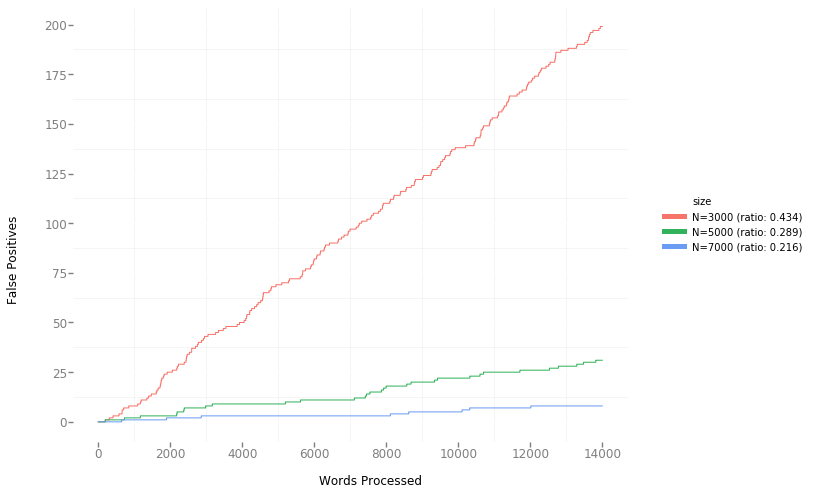

<ggplot: (-9223372036551371874)>

In [21]:
ggplot(aes(x='x', y='error', group='size', color='size'), data=df) + geom_step() \
    + xlab('Words Processed') + ylab('False Positives') + theme_bw()

There are many variants and applications for Bloom Filters, for this work I will only introduce two of them. For a length overview of its many uses I recommend the article titled "Theory and Practice of Bloom Filters for
Distributed Systems" <cite data-cite="4353254/BCNSDS4D"></cite>.

### Counting Bloom Filters
By default Bloom Filters do not support removal of elements, as many elements may have at least one position in common, and thus marking 0 where one element is hashed to may invalidate many others. One can get around this problem by going from bits to counters, although overflow might be a problem. This variant is called Counting Bloom Filters <cite data-cite="4353254/MF7X8UXP"></cite>.

Besides the ability of removing elements, one can use its counters to report the frequency of the elements. As a single position may be incremented by many elements, the sensible thing to do is to compute the minimum of the $d$ addresses (note that this implementation will never underestimate).

In [22]:
N = 5000
bitmap = np.array([0] * N)
subset = words[0:7000]

for w in subset:
    for hash_function in hash_functions:
        bitmap[hash_function(w) % N] += 1

In [23]:
true_freq = nltk.FreqDist(subset).most_common(25)[5:]

df = pd.DataFrame(data=0, index=(0, 2 * (len(true_freq) - 1)), columns=['word', 'frequency', 'f'])
for idx, (w, true) in enumerate(true_freq):
    freq = -1
    for hash_function in hash_functions:
        cnt = bitmap[hash_function(w) % N]
        if freq == -1 or cnt < freq:
            freq = cnt
            
    df.loc[idx * 2] = [w, freq, 'Counting Bloom Filter']
    df.loc[idx * 2 + 1] = [w, true, 'True Frequency']

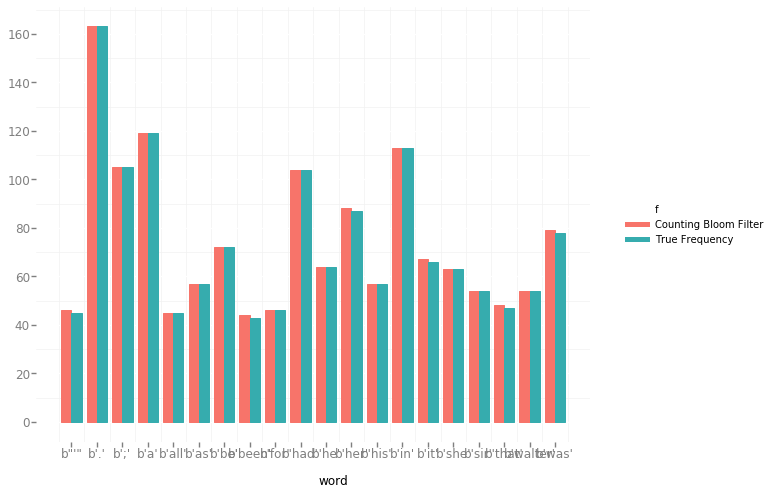

<ggplot: (-9223372036549889704)>

In [24]:
ggplot(aes(x='word', weight='frequency', fill='f'), df) + geom_bar() + theme_bw()

### Stable Bloom Filters

Being able to selectively remove one element is a good addition, but sometimes one needs to continuosly remove old/stale data. For example, imagine a case where there is a stream of data and one needs to check if the newly arrived element is unique or not. If there are infinitely many unique elements, then having false negatives is unavoidable, as it is impossible to keep all of them. Moreover, we can't keep too many of them as the bitmap would be filled with 1s and thus increase the false positive ratio. One possible solution to acheive a balance between false positivies and false negatives is to continuosly remove the old/stale data. This variant is called Stable Bloom Filters (SBF) <cite data-cite="4353254/UHRIAPXZ"></cite> and uses the counter to also store time related information. At SBF, whenever doing an insertion, firstly one selects $P$ random positions of the bitmap and decrements them by 1, then at each of the $d$ addresses you set the counter to a maximum value instead of 1. This way data that is not accessed often is going to be forgotten, and data that is often accessed has a large counter value.

## References
<div class="cite2c-biblio"></div>